<a href="https://colab.research.google.com/github/promihamid/CSE468/blob/main/cifar100_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ---------- PART 1: SETUP ----------
# Install timm (PyTorch image models library)
!pip install -q timm

# Import necessary libraries
import os
import math
import time
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [8]:
# ---------- PART 2: CONFIGURATION ----------
from pathlib import Path
import torch

# Dataset / model choice
DATASET = "CIFAR100"               # we're using CIFAR-100
NUM_CLASSES = 100

# Model (timm model name). Change to "vit_small_patch16_224" if GPU is tight.
MODEL_NAME = "vit_base_patch16_224"
PRETRAINED = True                  # use pretrained weights (important for good perf ≤20 epochs)

# Image & batch params
IMG_SIZE = 224                     # ViT standard input size (resize CIFAR images)
BATCH_SIZE = 128                   # increase if you have more GPU memory
NUM_WORKERS = 4                    # DataLoader workers (set 0 on some Windows/Colab issues)

# Training schedule (must be <=20 per your requirement)
EPOCHS = 20
LR = 3e-4                          # base learning rate (AdamW)
WEIGHT_DECAY = 0.05                # AdamW weight decay
MIXUP_ALPHA = 0.8                  # set 0 to disable mixup
LABEL_SMOOTH = 0.1                 # label smoothing for CE
DROP_PATH_RATE = 0.0               # for models that support stochastic depth (keep 0-0.2)

# Misc
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_DIR = Path("checkpoints")
OUT_DIR.mkdir(exist_ok=True)
PRINT_FREQ = 1                      # how often to print logs (in loops using tqdm we show progress)

# Mixed precision (helps increase batch size without OOM)
USE_AMP = True                       # set False if you want plain fp32 training

# Reproducibility (optional)
SEED = 42

# Print summary
print(f"Dataset: {DATASET} | Model: {MODEL_NAME} | IMG_SIZE: {IMG_SIZE} | Batch: {BATCH_SIZE} | Epochs: {EPOCHS}")
print(f"Device: {DEVICE} | Pretrained: {PRETRAINED} | AMP: {USE_AMP}")


Dataset: CIFAR100 | Model: vit_base_patch16_224 | IMG_SIZE: 224 | Batch: 128 | Epochs: 20
Device: cuda | Pretrained: True | AMP: True


In [9]:
# ---------- PART 3: DATA TRANSFORMS & DATALOADERS ----------
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch

# CIFAR-100 channel stats (used for normalization)
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

# TRAIN transforms: resize -> augment -> tensor -> normalize
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),         # ViT expects bigger size than 32x32
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.RandAugment(num_ops=2, magnitude=9), # strong augmentation to avoid overfit
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

# VAL / TEST transforms: deterministic
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

# Load datasets (downloads if not present)
if DATASET.upper() == "CIFAR100":
    train_dataset = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=train_transforms)
    val_dataset   = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=val_transforms)
else:
    raise ValueError("This script currently supports CIFAR100 for the mentor recipe. Change DATASET or add loader.")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Batches/train: {len(train_loader)}")

# ---------- MixUp helper ----------
def mixup_data(x, y, alpha=MIXUP_ALPHA, device=DEVICE):
    """
    Returns mixed inputs, pairs of targets, and lambda.
    If alpha <= 0, returns original inputs and labels (no mixup).
    """
    if alpha is None or alpha <= 0:
        return x, y, None, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


Train size: 50000 | Val size: 10000 | Batches/train: 390


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
# ---------- PART 4: MODEL, OPTIM, SCHEDULER, LOSS ----------
import timm
import torch
import torch.nn as nn
import math

# ----- Create model -----
model = timm.create_model(MODEL_NAME, pretrained=PRETRAINED, num_classes=NUM_CLASSES)

# If the model has a classifier we can add dropout to head to help regularize.
# Different timm models expose different names; this is a safe attempt.
def add_dropout_to_head(m, p=0.1):
    """
    Wrap the classifier head with (Dropout -> Linear) if possible.
    If no compatible attribute found, this routine is a no-op.
    """
    p = float(p)
    # common names: 'head', 'fc', 'classifier', 'head.fc', 'pre_logits'...
    if hasattr(m, 'head') and isinstance(m.head, nn.Linear):
        m.head = nn.Sequential(nn.Dropout(p), m.head)
    elif hasattr(m, 'fc') and isinstance(m.fc, nn.Linear):
        m.fc = nn.Sequential(nn.Dropout(p), m.fc)
    elif hasattr(m, 'classifier') and isinstance(m.classifier, nn.Linear):
        m.classifier = nn.Sequential(nn.Dropout(p), m.classifier)
    else:
        # Try reset_classifier if available (timm models often support it)
        try:
            # reset_classifier accepts num_classes and optionally drop_rate
            m.reset_classifier(num_classes=NUM_CLASSES, global_pool='avg')
            if hasattr(m, 'head'):
                m.head = nn.Sequential(nn.Dropout(p), m.head)
        except Exception:
            # fallback: no modification
            pass

# Add small dropout on head if you want extra regularization
HEAD_DROPOUT = 0.1   # set to 0.0 to disable
if HEAD_DROPOUT > 0:
    add_dropout_to_head(model, p=HEAD_DROPOUT)

# Move to device
model = model.to(DEVICE)

# Print model size / param count
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print(f"Model: {MODEL_NAME} | Params (trainable): {count_params(model):,}")

# ----- Loss -----
# Use label smoothing for CrossEntropy (beneficial when not using mixup)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH).to(DEVICE)

# ----- Optimizer -----
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# ----- Scheduler: Cosine with warmup (per-step lambda LR) -----
def get_cosine_with_warmup(optimizer, num_epochs, steps_per_epoch, warmup_epochs=2):
    total_steps = num_epochs * steps_per_epoch
    warmup_steps = int(warmup_epochs * steps_per_epoch)
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_cosine_with_warmup(optimizer, num_epochs=EPOCHS, steps_per_epoch=len(train_loader), warmup_epochs=2)

# ----- AMP scaler for mixed precision -----
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP and DEVICE.startswith("cuda"))

print("Setup complete: optimizer, scheduler, criterion, AMP scaler ready.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model: vit_base_patch16_224 | Params (trainable): 85,875,556
Setup complete: optimizer, scheduler, criterion, AMP scaler ready.


/tmp/ipython-input-4100377002.py:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP and DEVICE.startswith("cuda"))


In [11]:
# ---------- PART 5a: METRICS & UTILITIES ----------
import torch
import torch.nn.functional as F
from pathlib import Path

# Top-k accuracy (returns percentages)
def accuracy_topk(output, target, topk=(1,5)):
    """
    output: (B, C) logits
    target: (B,) long
    returns: list of floats corresponding to topk accuracies in percent
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)   # (B, maxk)
        pred = pred.t()                              # (maxk, B)
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(float(correct_k.mul_(100.0 / batch_size)))
    return res

# Safe checkpoint save helper (saves model + optimizer states)
def save_checkpoint(path, model, optimizer, epoch, val_top5):
    path = Path(path)
    try:
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_top5": val_top5,
        }, path)
        print(f"Saved checkpoint: {path}")
    except Exception as e:
        print("Warning: checkpoint save failed:", e)


In [12]:
# ---------- PART 5b: SINGLE TRAIN STEP ----------
def train_step(model, optimizer, images, targets, criterion, scaler=None, use_amp=True, mixup_alpha=0.0, device="cuda"):
    """
    Performs forward, backward, optimizer step for one batch.
    Returns: loss (float), top1 (float %), top5 (float %)
    """
    model.train()
    images = images.to(device); targets = targets.to(device)

    # MixUp (returns mixed inputs and two label sets + lambda)
    if mixup_alpha and mixup_alpha > 0:
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        idx = torch.randperm(images.size(0)).to(device)
        images_m = lam * images + (1 - lam) * images[idx]
        targets_a, targets_b = targets, targets[idx]
    else:
        lam = None
        images_m = images
        targets_a = targets_b = None

    optimizer.zero_grad()
    with torch.cuda.amp.autocast(enabled=(use_amp and device.startswith("cuda"))):
        outputs = model(images_m)
        if lam is not None:
            loss = lam * F.cross_entropy(outputs, targets_a) + (1 - lam) * F.cross_entropy(outputs, targets_b)
        else:
            loss = criterion(outputs, targets)

    # Backward + step
    if scaler is not None:
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    else:
        loss.backward()
        optimizer.step()

    # Compute metrics on the original targets (for reporting)
    top1, top5 = accuracy_topk(outputs.detach(), targets, topk=(1,5))
    return float(loss.item()), top1, top5


In [13]:
# ---------- PART 5c: TRAINING EPOCH ----------
from tqdm import tqdm
def train_one_epoch(model, train_loader, optimizer, criterion, scaler, scheduler=None,
                    use_amp=True, mixup_alpha=0.0, device="cuda"):
    model.train()
    running_loss = 0.0
    running_top1 = 0.0
    running_top5 = 0.0
    n = 0

    pbar = tqdm(train_loader, desc="Train", leave=False)
    for images, targets in pbar:
        loss, top1, top5 = train_step(model, optimizer, images, targets, criterion,
                                      scaler=scaler, use_amp=use_amp, mixup_alpha=mixup_alpha, device=device)
        bs = images.size(0)
        running_loss += loss * bs
        running_top1 += (top1/100.0) * bs
        running_top5 += (top5/100.0) * bs
        n += bs

        # scheduler step per batch (if provided)
        if scheduler is not None:
            try:
                scheduler.step()
            except Exception:
                pass

        pbar.set_postfix(loss=f"{running_loss/n:.4f}", top1=f"{100*running_top1/n:.2f}", top5=f"{100*running_top5/n:.2f}")

    train_loss = running_loss / n
    train_top1 = 100 * running_top1 / n
    train_top5 = 100 * running_top5 / n
    return train_loss, train_top1, train_top5


In [14]:
# ---------- PART 5d: VALIDATION EPOCH ----------
def validate_one_epoch(model, val_loader, criterion, use_amp=True, device="cuda"):
    model.eval()
    val_loss = 0.0
    val_top1 = 0.0
    val_top5 = 0.0
    n = 0
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Val", leave=False)
        for images, targets in pbar:
            images = images.to(device); targets = targets.to(device)
            with torch.cuda.amp.autocast(enabled=(use_amp and device.startswith("cuda"))):
                outputs = model(images)
                loss = criterion(outputs, targets)
            top1, top5 = accuracy_topk(outputs, targets, topk=(1,5))
            bs = images.size(0)
            val_loss += float(loss.item()) * bs
            val_top1 += (top1/100.0) * bs
            val_top5 += (top5/100.0) * bs
            n += bs
            pbar.set_postfix(vloss=f"{val_loss/n:.4f}", vtop1=f"{100*val_top1/n:.2f}", vtop5=f"{100*val_top5/n:.2f}")

    val_loss = val_loss / n
    val_top1 = 100 * val_top1 / n
    val_top5 = 100 * val_top5 / n
    return val_loss, val_top1, val_top5


In [15]:
# ---------- PART 5e: EPOCH LOOP (orchestration) ----------
PATIENCE = 6
best_val_top5 = 0.0
best_epoch = -1
no_improve = 0

history = {"train_loss":[], "train_top1":[], "train_top5":[], "val_loss":[], "val_top1":[], "val_top5":[]}

for epoch in range(1, EPOCHS+1):
    print(f"\n=== Epoch {epoch}/{EPOCHS} ===")
    t0 = time.time()
    # Train
    train_loss, train_top1, train_top5 = train_one_epoch(
        model, train_loader, optimizer, criterion, scaler, scheduler,
        use_amp=USE_AMP, mixup_alpha=MIXUP_ALPHA, device=DEVICE
    )

    # Validate
    val_loss, val_top1, val_top5 = validate_one_epoch(
        model, val_loader, criterion, use_amp=USE_AMP, device=DEVICE
    )

    history["train_loss"].append(train_loss); history["train_top1"].append(train_top1); history["train_top5"].append(train_top5)
    history["val_loss"].append(val_loss); history["val_top1"].append(val_top1); history["val_top5"].append(val_top5)

    elapsed = time.time() - t0
    print(f"Epoch {epoch} done in {elapsed:.1f}s | train_loss={train_loss:.4f} train_top1={train_top1:.2f} train_top5={train_top5:.2f} | val_loss={val_loss:.4f} val_top1={val_top1:.2f} val_top5={val_top5:.2f}")

    # Checkpointing by val_top5
    if val_top5 > best_val_top5 + 1e-6:
        best_val_top5 = val_top5
        best_epoch = epoch
        no_improve = 0
        save_checkpoint(OUT_DIR / f"best_vtop5_epoch{epoch:.2f}.pth", model, optimizer, epoch, val_top5)
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= PATIENCE:
        print(f"No improvement for {PATIENCE} epochs, stopping early. Best val_top5={best_val_top5:.2f} at epoch {best_epoch}")
        break

print(f"Training finished. Best val_top5={best_val_top5:.2f} at epoch {best_epoch}")



=== Epoch 1/20 ===


Train:   0%|          | 0/390 [00:00<?, ?it/s]/tmp/ipython-input-2094954457.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.startswith("cuda"))):
Val:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-3615490225.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.startswith("cuda"))):


Epoch 1 done in 453.3s | train_loss=2.5112 train_top1=27.69 train_top5=44.39 | val_loss=1.3551 val_top1=82.36 val_top5=97.63
Saved checkpoint: checkpoints/best_vtop5_epoch1.00.pth

=== Epoch 2/20 ===


Epoch 2 done in 448.8s | train_loss=2.0292 train_top1=35.20 train_top5=54.73 | val_loss=1.4287 val_top1=79.20 val_top5=96.33

=== Epoch 3/20 ===


Epoch 3 done in 447.2s | train_loss=1.9993 train_top1=38.59 train_top5=58.18 | val_loss=1.3735 val_top1=80.37 val_top5=96.67

=== Epoch 4/20 ===


Epoch 4 done in 447.3s | train_loss=1.9434 train_top1=40.33 train_top5=60.89 | val_loss=1.3971 val_top1=79.69 val_top5=96.42

=== Epoch 5/20 ===


Epoch 5 done in 447.7s | train_loss=1.8414 train_top1=38.87 train_top5=59.48 | val_loss=1.3449 val_top1=81.94 val_top5=96.90

=== Epoch 6/20 ===


Epoch 6 done in 446.5s | train_loss=1.7680 train_top1=42.32 train_top5=63.48 | val_loss=1.3484 val_top1=82.33 val_top5=96.78

=== Epoch 7/20 ===


Epoch 7 done in 447.0s | train_loss=1.6866 train_top1=41.36 train_top5=62.31 | val_loss=1.3072 val_top1=83.01 val_top5=97.06
No improvement for 6 epochs, stopping early. Best val_top5=97.63 at epoch 1
Training finished. Best val_top5=97.63 at epoch 1


In [16]:
# ---------- PART 5f: FINAL EVAL & PLOTS ----------
# Load best checkpoint if available
best_ckpts = sorted(OUT_DIR.glob("best_vtop5_epoch*.pth"))
if best_ckpts:
    ckpt = torch.load(best_ckpts[-1], map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    print(f"Loaded best checkpoint from epoch {ckpt.get('epoch', '?')} with val_top5={ckpt.get('val_top5', '?'):.2f}")

# Final evaluation
test_loss, test_top1, test_top5 = validate_one_epoch(model, val_loader, criterion, use_amp=USE_AMP, device=DEVICE)
print(f"\nFINAL: loss={test_loss:.4f} | top1={test_top1:.2f}% | top5={test_top5:.2f}%")




Loaded best checkpoint from epoch 1 with val_top5=97.63


Val:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-3615490225.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.startswith("cuda"))):
                                                                                            


FINAL: loss=1.3551 | top1=82.36% | top5=97.63%


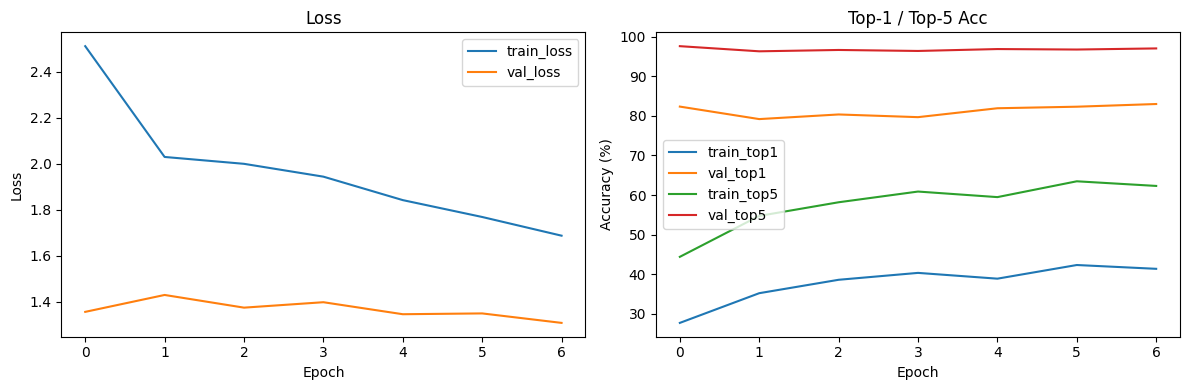

In [17]:
# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_top1"], label="train_top1")
plt.plot(history["val_top1"], label="val_top1")
plt.plot(history["train_top5"], label="train_top5")
plt.plot(history["val_top5"], label="val_top5")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Top-1 / Top-5 Acc"); plt.legend()
plt.tight_layout()
plt.show()